# Project

Consider the response of two components in an automobile, both modelled as oscillators, subjected to support motion acceleration modelled as mean zero stationary process with auto-PSD
$$ S_{FF}(\omega) = \frac{6}{400+\omega^2} $$
(Assume $F$ is a mean zero (second order weak sense) stationary process.)

Each oscillator is modelled as a sdof system,
$$ \ddot{x}_j (t) + 2 \zeta_j \omega_j \dot{x}_j (t) + \omega_j^2 x_j (t) = f(t) $$
where $\omega_1 = 10$, $\zeta_1 = 0.01$ and $\omega_2 = 15$, $\zeta_1 = 0.005$.

The FRF thus is given by
$$ H_j(\omega) = \frac{1}{(\omega_j^2 - \omega^2) + 2 i \zeta_j \omega_j \omega } $$

In [1]:
import numpy as np
import sympy as sp
import scipy as sc
from scipy import integrate, stats, linalg, special
from scipy.stats import norm
from scipy.integrate import simps
from scipy.signal import periodogram
from scipy.fft import fft, ifft, fftfreq

import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
def plot_histogram(data, bins=100, density=True, moving=10):
    counts, bins = np.histogram(data, bins=bins, density=True)
    counts = np.convolve(counts, np.ones(moving)/moving, mode='same')
    return bins, counts

In [3]:
w_1, w_2 = 10, 15
zeta_1, zeta_2 = 0.01, 0.005

w, w_j = sp.symbols('omega, omega_j', real=True)
zeta_j = sp.symbols('zeta_j', real=True)

S_FF = 6/(400+w**2)
S_FF_lambda = sp.lambdify(w, S_FF)
S_FF_num = np.vectorize(S_FF_lambda)

Hj = 1/((w_j**2-w**2)+1j*2*zeta_j*w_j*w)

tau = sp.symbols('tau', real=True)
R_FF = sp.exp(-20*sp.Abs(tau)) * 6/40
R_FF_lambda = sp.lambdify(tau, R_FF)
R_FF_num = np.vectorize(R_FF_lambda)

In [4]:
mu_f = 0
sigma2_f = integrate.quad(S_FF_lambda, -np.inf, np.inf)[0]/(2*np.pi)
f = sp.symbols('f', real=True)

p_F = 1/(sp.sqrt(2*sp.pi*sigma2_f))*sp.exp(-(f-mu_f)**2/(2*sigma2_f))
p_F_lambda = sp.lambdify(f, p_F)
p_F_num = np.vectorize(p_F_lambda)

---

In [5]:
N = 8196
ws = 100

b = 0.01

In [6]:
dw = ws/N
dt = 2*np.pi/ws

rows = np.arange(0, N, 1).reshape(-1, 1)
cols = np.arange(0, N, 1).reshape(1, -1)

rows_ = np.repeat(rows, N, axis=1)
cols_ = np.repeat(cols, N, axis=0)
C_ind = np.abs(rows_ - cols_)

In [7]:
C = R_FF_num(C_ind*dt)
C[np.abs(C) < 1e-8] = 0

D = linalg.cholesky(C)

---

In [8]:
def sdof(y, t, w_j, zeta_j, f):
    y0dot = y[1]
    y1dot = f(t) - 2*zeta_j*w_j*y[1] - w_j**2*y[0]
    return np.array([y0dot, y1dot])

In [9]:
# special.eval_hermitenorm(3, 1)

def hermite(n, xi):
    if n == 0:
        return 1
    elif n == 1:
        return xi
    elif n == 2:
        return xi**2 - 1
    else:
        return xi*hermite(n-1, xi) - (n-1)*hermite(n-2, xi)
    
def pdf_zeta(zeta):
    pdf = 1./np.sqrt(2*np.pi) * np.exp(-0.5*zeta**2)
    return pdf

def inverse_cdf_gaussian(x, mu=0, sigma2=1):
    return np.sqrt(2*sigma2)*special.erfinv(2*x-1) + mu

---

In [10]:
wvec = np.arange(-N/2, N/2, 1)*dw
tvec = np.arange(0, N, 1)*dt

fvec = np.linspace(-1, 1, N)
xvec = np.linspace(-0.1, 0.1, N)
yvec = np.linspace(-1, 1, N)

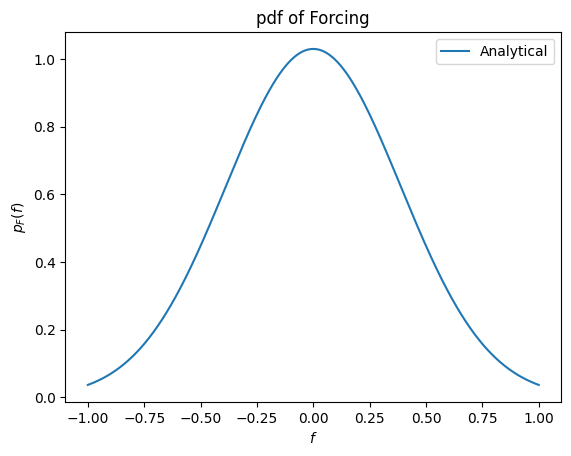

In [11]:
p_F_analytical = np.nan_to_num(p_F_num(fvec), copy=False)

plt.plot(fvec, p_F_analytical, label='Analytical')

plt.xlabel('$f$')
plt.ylabel('$p_F(f)$')
plt.title('pdf of Forcing')
plt.legend()
plt.savefig('pdf_F_1.svg', bbox_inches='tight', transparent=True, format="svg")

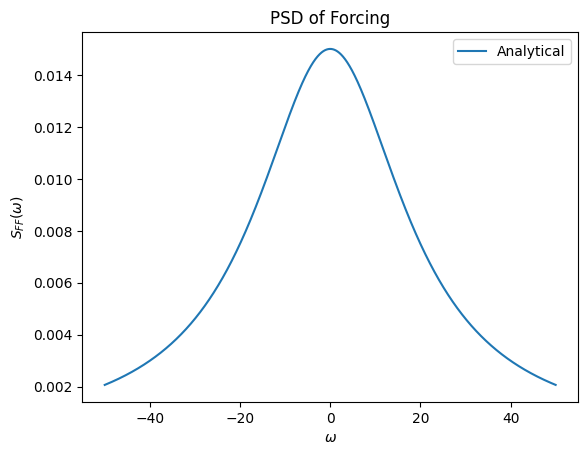

In [12]:
s_FF_analytical = np.nan_to_num(S_FF_num(wvec), copy=False)

plt.plot(wvec, s_FF_analytical, label='Analytical')

plt.xlabel('$\omega$')
plt.ylabel('$S_{FF}(\omega)$')
plt.title('PSD of Forcing')
plt.legend()
plt.savefig('psd_F.svg', bbox_inches='tight', transparent=True, format="svg")

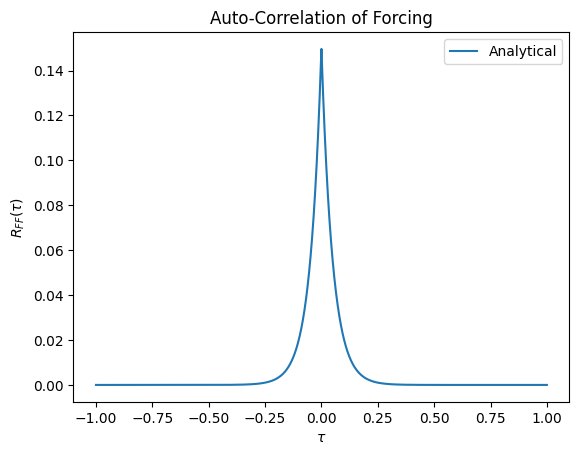

In [13]:
rvec = np.linspace(-1, 1, N)
r_FF_analytical = np.nan_to_num(R_FF_num(rvec), copy=False)

plt.plot(rvec, r_FF_analytical, label='Analytical')

plt.xlabel('$\\tau$')
plt.ylabel('$R_{FF}(\\tau)$')
plt.title('Auto-Correlation of Forcing')
plt.legend()
plt.savefig('r_F_1.svg', bbox_inches='tight', transparent=True, format="svg")

## Part 1

Let $b$ the static clearance between the two oscillators. This gives the clearance between the two components during operating conditions as 
$$Y = b - X_1 + X_2$$
Analytically, find the stationary pdf for $Y$, assuming that $X_1$ and $X_2$ are independent.

In [14]:
S_XX = S_FF*(Hj*sp.conjugate(Hj)).simplify()

S_X1X1 = S_XX.subs({w_j: w_1, zeta_j: zeta_1})
S_X1X1_lambda = sp.lambdify(w, S_X1X1)
S_X1X1_num = np.vectorize(S_X1X1_lambda)
mu_x1 = 0
sigma2_x1 = integrate.quad(S_X1X1_lambda, -np.inf, np.inf)[0]/(2*np.pi)

S_X2X2 = S_XX.subs({w_j: w_2, zeta_j: zeta_2})
SX2X2_lambda = sp.lambdify(w, S_X2X2)
SX2X2_num = np.vectorize(SX2X2_lambda)
mu_x2 = 0
sigma2_x2 = integrate.quad(SX2X2_lambda, -np.inf, np.inf)[0]/(2*np.pi)

In [15]:
s_X1X1_analytical = np.nan_to_num(S_X1X1_num(wvec), copy=False)
s_X2X2_analytical = np.nan_to_num(SX2X2_num(wvec), copy=False)

In [16]:
x = sp.symbols('x', real=True)
mu_x = sp.symbols('mu_x', real=True)
sigma_x = sp.symbols('sigma_x', real=True)

p_X = 1/(sp.sqrt(2*sp.pi)*sigma_x)*sp.exp(-(x-mu_x)**2/(2*sigma_x**2))


y, x_1, x_2 = sp.symbols('y, x_1, x_2', real=True)

p_X1 = p_X.subs({x: x_1, mu_x: mu_x1, sigma_x: sp.sqrt(sigma2_x1)})
p_X1_lambda = sp.lambdify(x_1, p_X1)
p_X1_num = np.vectorize(p_X1_lambda)

p_X2 = p_X.subs({x: x_2, mu_x: mu_x2, sigma_x: sp.sqrt(sigma2_x2)})
p_X2_lambda = sp.lambdify(x_2, p_X2)
p_X2_num = np.vectorize(p_X2_lambda)


def get_p_Y_analytical(b):
    p_Y = sp.integrate(p_X1*p_X2.subs({x_2: y-b+x_1}), (x_1, -sp.oo, sp.oo))
    p_Y_lambda = sp.lambdify(y, p_Y)
    return p_Y_lambda

In [17]:
p_X1_analytical = np.nan_to_num(p_X1_num(xvec), copy=False)
p_X2_analytical = np.nan_to_num(p_X2_num(xvec), copy=False)

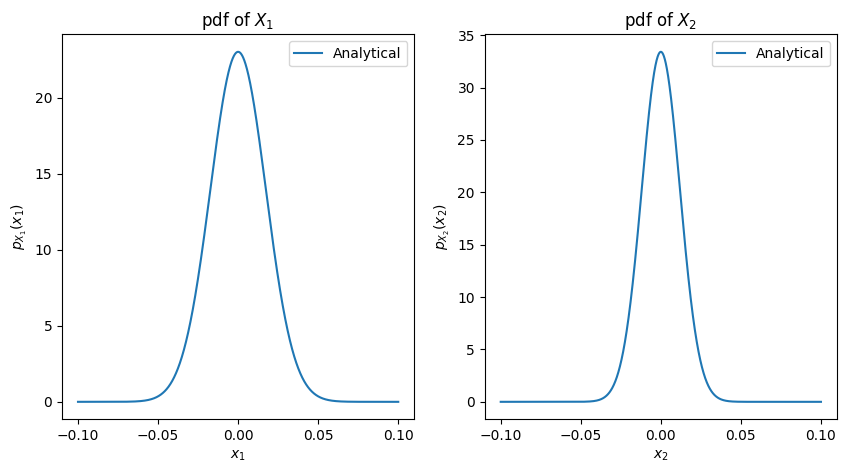

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(xvec, p_X1_analytical, label='Analytical')

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$p_{X_1}(x_1)$')
ax[0].set_title('pdf of $X_1$')
ax[0].legend()


ax[1].plot(xvec, p_X2_analytical, label='Analytical')

ax[1].set_xlabel('$x_2$')
ax[1].set_ylabel('$p_{X_2}(x_2)$')
ax[1].set_title('pdf of $X_2$')
ax[1].legend()
plt.savefig('pdf_X1X2_1.svg', bbox_inches='tight', transparent=True, format="svg")

---

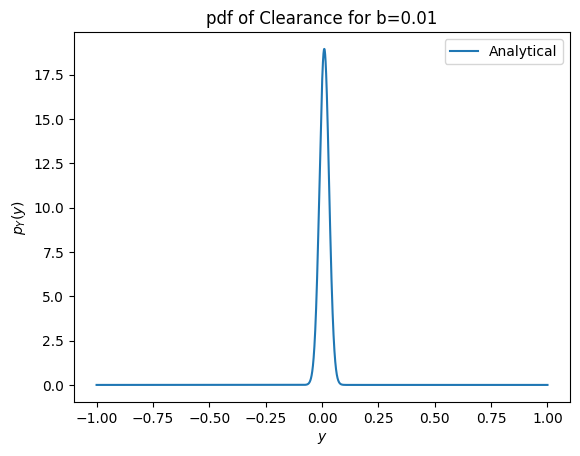

In [19]:
p_Y_lambda = np.vectorize(get_p_Y_analytical(b))
p_Y_analytical = p_Y_lambda(yvec)

plt.plot(yvec, p_Y_analytical, label='Analytical')
plt.xlabel('$y$')
plt.ylabel('$p_Y(y)$')
plt.title(f'pdf of Clearance for b={b}')
plt.legend()
plt.savefig('clearance_1.svg', bbox_inches='tight', transparent=True, format="svg")

In [20]:
def collision_analytical(b, p_X1, p_X2):
    p_Y = sp.integrate(p_X1*p_X2.subs({x_2: y-b+x_1}), (x_1, -sp.oo, sp.oo))
    p_Y_lambda = sp.lambdify(y, p_Y)
    p_Y_num = np.vectorize(p_Y_lambda)
    return p_Y_num(0)

## Part 2

Next, simulate the random forcing and show that the simulated forcings match the target pdfs and the target PSDs.

In [21]:
white_noise = stats.norm.rvs(size=N)

f_numerical = np.real(np.dot(D, white_noise))

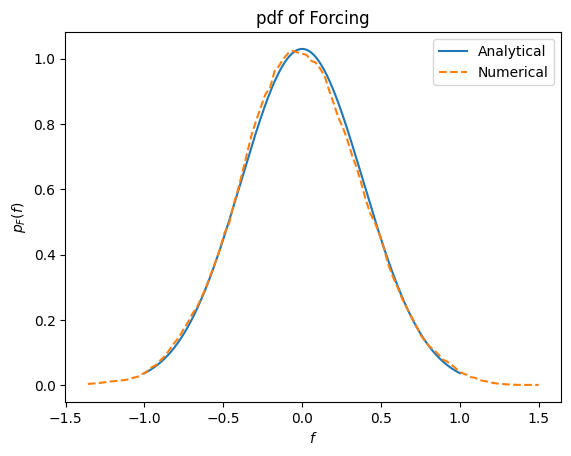

In [22]:
plt.plot(fvec, p_F_analytical, label='Analytical')

bins, counts = plot_histogram(f_numerical, bins=100)
plt.plot(bins[:-1], counts, label='Numerical', linestyle='--')

plt.xlabel('$f$')
plt.ylabel('$p_F(f)$')
plt.title('pdf of Forcing')
plt.legend()
plt.savefig('pdf_F_2.svg', bbox_inches='tight', transparent=True, format="svg")

---

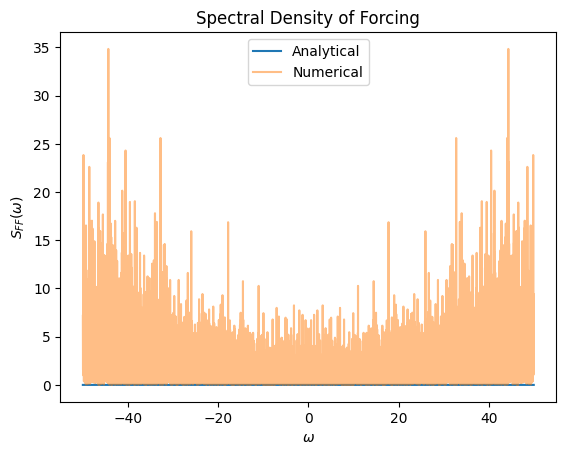

In [23]:
s_FF_numerical = np.abs(np.fft.fft(f_numerical))**2/(N*dt)

plt.plot(wvec, s_FF_analytical, label='Analytical')
plt.plot(wvec, s_FF_numerical, label='Numerical', alpha=0.5,)

plt.xlabel('$\omega$')
plt.ylabel('$S_{FF}(\omega)$')
plt.title('Spectral Density of Forcing')
plt.legend()
plt.savefig('psd_F_2.svg', bbox_inches='tight', transparent=True, format="svg")

## Part 3

Use the simulated forcings as input and numerically integrate the equations. Plot sample time histories of $x_1(t)$ and $x_2(t)$. Show that the probabilistic characterizers match the analytically derived pdfs and PSDs.

$$ \ddot{x}_j (t) + 2 \zeta_j \omega_j \dot{x}_j (t) + \omega_j^2 x_j (t) = f(t) $$

In [24]:
ft = lambda t: f_numerical[int(t/dt)]

x1 = integrate.odeint(sdof, np.array([0, 0]), tvec, args=(w_1, zeta_1, ft))
x2 = integrate.odeint(sdof, np.array([0, 0]), tvec, args=(w_2, zeta_2, ft))

x1_numerical = x1[:, 0]
x2_numerical = x2[:, 0]

y_numerical = b - x1_numerical + x2_numerical

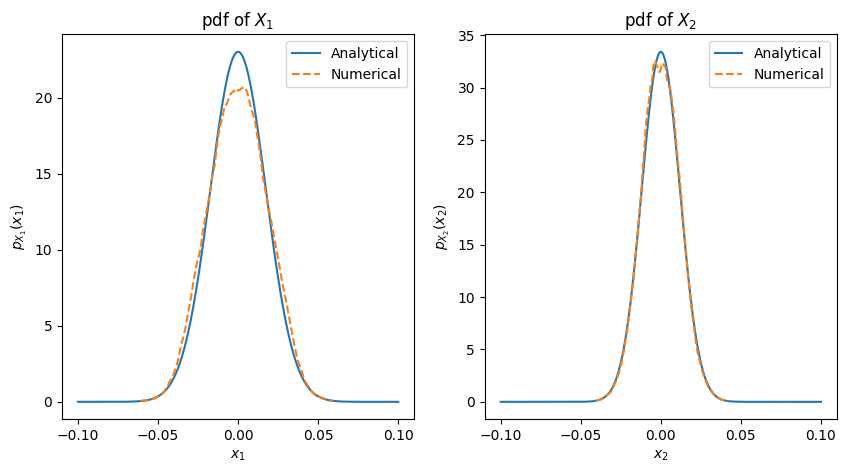

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(xvec, p_X1_analytical, label='Analytical')

bins, counts = plot_histogram(x1_numerical, bins=100)
ax[0].plot(bins[:-1], counts, label='Numerical', linestyle='--')

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$p_{X_1}(x_1)$')
ax[0].set_title('pdf of $X_1$')
ax[0].legend()


ax[1].plot(xvec, p_X2_analytical, label='Analytical')

bins, counts = plot_histogram(x2_numerical, bins=100)
ax[1].plot(bins[:-1], counts, label='Numerical', linestyle='--')

ax[1].set_xlabel('$x_2$')
ax[1].set_ylabel('$p_{X_2}(x_2)$')
ax[1].set_title('pdf of $X_2$')
ax[1].legend()
plt.savefig('pdf_X1X2_2.svg', bbox_inches='tight', transparent=True, format="svg")

---

In [26]:
s_X1X1_numerical = np.fft.fftshift(np.fft.fft(np.fft.fftshift(x1_numerical)))**2 / (2*N+1)
s_X2X2_numerical = np.fft.fftshift(np.fft.fft(np.fft.fftshift(x2_numerical)))**2 / (2*N+1)

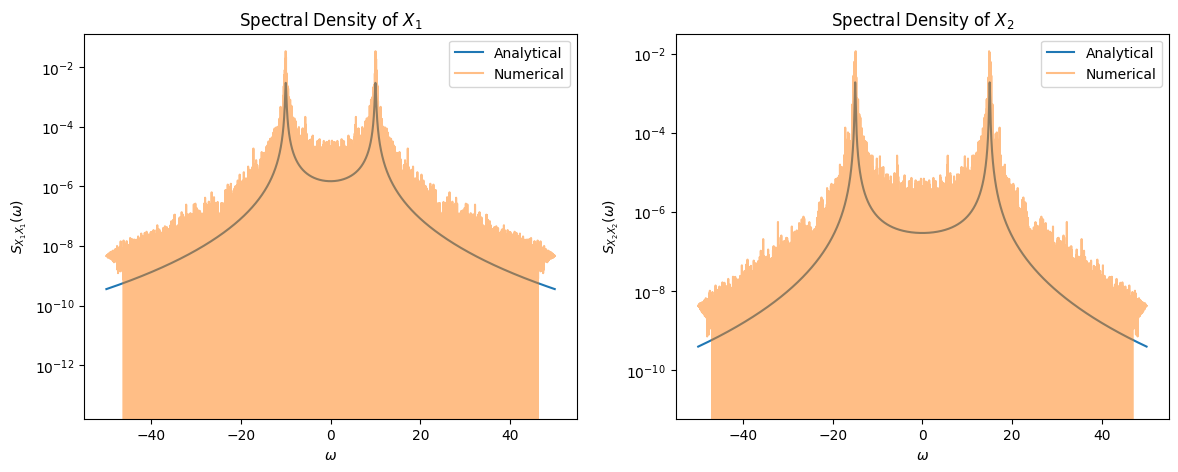

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].semilogy(wvec, s_X1X1_analytical, label='Analytical')
ax[0].semilogy(wvec, s_X1X1_numerical, label='Numerical', alpha=0.5)
ax[0].set_xlabel('$\omega$')
ax[0].set_ylabel('$S_{X_1X_1}(\omega)$')
ax[0].set_title('Spectral Density of $X_1$')
ax[0].legend()

ax[1].semilogy(wvec, s_X2X2_analytical, label='Analytical')
ax[1].semilogy(wvec, s_X2X2_numerical, label='Numerical', alpha=0.5)
ax[1].set_xlabel('$\omega$')
ax[1].set_ylabel('$S_{X_2X_2}(\omega)$')
ax[1].set_title('Spectral Density of $X_2$')
ax[1].legend()

plt.savefig('psd_X1X2_2.svg', bbox_inches='tight', transparent=True, format="svg")

---

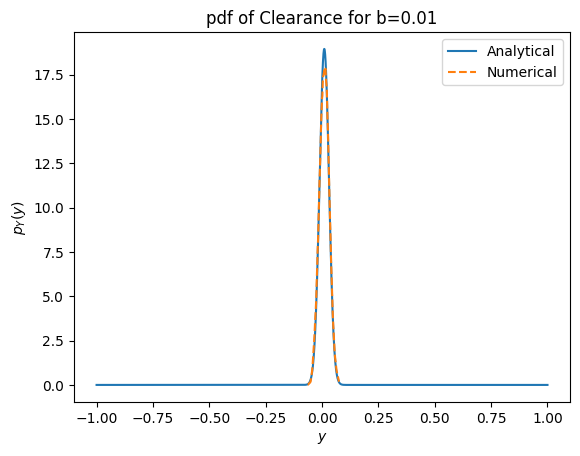

In [28]:
plt.plot(yvec, p_Y_analytical, label='Analytical')

bins, counts = plot_histogram(y_numerical, bins=100)
plt.plot(bins[:-1], counts, label='Numerical', linestyle='--')


plt.xlabel('$y$')
plt.ylabel('$p_Y(y)$')
plt.title(f'pdf of Clearance for b={b}')
plt.legend()
plt.savefig('clearance_2.svg', bbox_inches='tight', transparent=True, format="svg")

In [29]:
def collision_numerical(b, x1_numerical, x2_numerical):
    y_generated = b - x1_numerical + x2_numerical
    bins, counts = plot_histogram(y_generated, bins=100)
    if bins[0] < 0 and 0 < bins[-1]:
        return np.interp(0, bins[:-1], counts)
    else:
        return 0

## Part 4

Next, derive the formulation for representing the response in PCE framework. Using PCE, numerically estimate the pdf of $Y$. Show graphically the accuracy of your PCE based estimate with the numerically obtained estimates. Comment on the accuracy and computational costs.

In [30]:
f0_int = lambda u: inverse_cdf_gaussian(u, 0, sigma2_f) * hermite(0, inverse_cdf_gaussian(u))
norm0_int = lambda u: hermite(0, u)**2 * pdf_zeta(u)
norm0 = integrate.quad(norm0_int, -np.inf, np.inf)[0]
f0 = integrate.quad(f0_int, 0, 1)[0]/norm0


f1_int = lambda u: inverse_cdf_gaussian(u, 0, sigma2_f) * hermite(1, inverse_cdf_gaussian(u))
norm1_int = lambda u: hermite(1, u)**2 * pdf_zeta(u)
norm1 = integrate.quad(norm1_int, -np.inf, np.inf)[0]
f1 = integrate.quad(f1_int, 0, 1)[0]/norm1

In [31]:
xi = np.random.normal(0, 1, size=N)

f_pce = f0 + f1 * hermite(1,  xi)

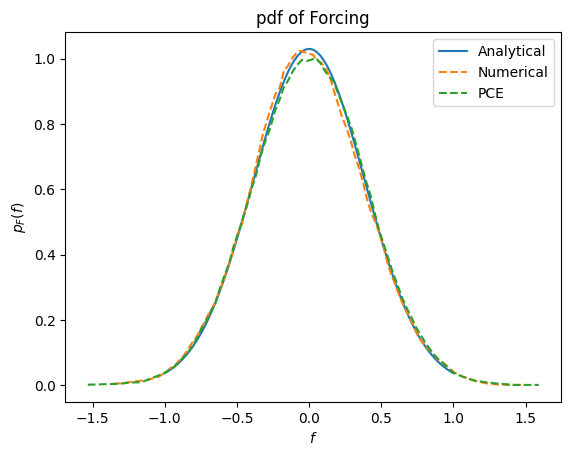

In [32]:
plt.plot(fvec, p_F_analytical, label='Analytical')

bins, counts = plot_histogram(f_numerical, bins=100)
plt.plot(bins[:-1], counts, label='Numerical', linestyle='--')

bins, counts = plot_histogram(f_pce, bins=100)
plt.plot(bins[:-1], counts, label='PCE', linestyle='--')

plt.xlabel('$f$')
plt.ylabel('$p_F(f)$')
plt.title('pdf of Forcing')
plt.legend()
plt.savefig('pdf_F_3.svg', bbox_inches='tight', transparent=True, format="svg")

---

In [33]:
F0 = lambda t: 0
F1 = lambda t: f_pce[int(t/dt)]

x1_0 = integrate.odeint(sdof, np.array([0, 0]), tvec, args=(w_1, zeta_1, F0))[:, 0]
x1_1 = integrate.odeint(sdof, np.array([0, 0]), tvec, args=(w_1, zeta_1, F1))[:, 0]

x2_0 = integrate.odeint(sdof, np.array([0, 0]), tvec, args=(w_2, zeta_2, F0))[:, 0]
x2_1 = integrate.odeint(sdof, np.array([0, 0]), tvec, args=(w_2, zeta_2, F1))[:, 0]

x1_pce = x1_0 + x1_1  * hermite(1, xi)
x2_pce = x2_0 + x2_1  * hermite(1, xi)

y_pce = b - x1_pce + x2_pce

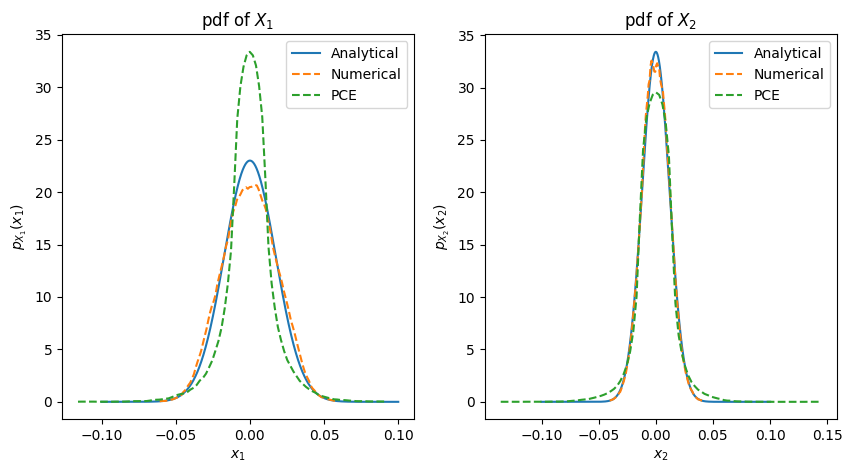

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(xvec, p_X1_analytical, label='Analytical')

bins, counts = plot_histogram(x1_numerical, bins=100)
ax[0].plot(bins[:-1], counts, label='Numerical', linestyle='--')

bins, counts = plot_histogram(x1_pce, bins=100)
ax[0].plot(bins[:-1], counts, label='PCE', linestyle='--')

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$p_{X_1}(x_1)$')
ax[0].set_title('pdf of $X_1$')
ax[0].legend()


ax[1].plot(xvec, p_X2_analytical, label='Analytical')

bins, counts = plot_histogram(x2_numerical, bins=100)
ax[1].plot(bins[:-1], counts, label='Numerical', linestyle='--')

bins, counts = plot_histogram(x2_pce, bins=100)
ax[1].plot(bins[:-1], counts, label='PCE', linestyle='--')

ax[1].set_xlabel('$x_2$')
ax[1].set_ylabel('$p_{X_2}(x_2)$')
ax[1].set_title('pdf of $X_2$')
ax[1].legend()
plt.savefig('pdf_X1X2_3.svg', bbox_inches='tight', transparent=True, format="svg")

---

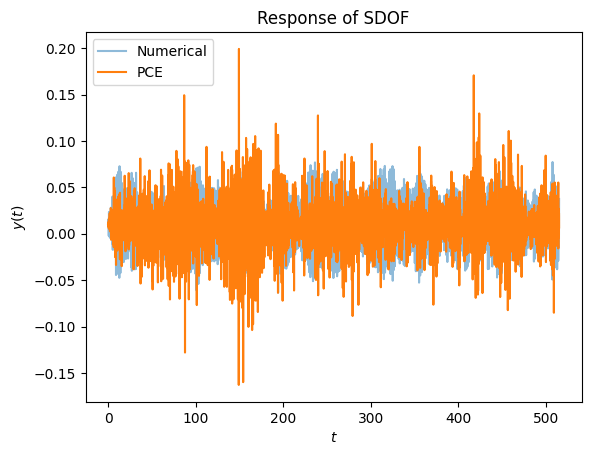

In [35]:
plt.plot(tvec, y_numerical, label='Numerical' , alpha=0.5)
plt.plot(tvec, y_pce, label='PCE')

plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.title('Response of SDOF')
plt.legend()
plt.savefig('response_3.svg', bbox_inches='tight', transparent=True, format="svg")

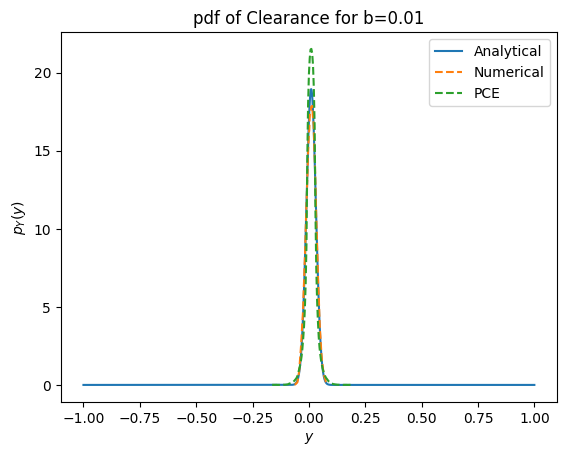

In [36]:
plt.plot(yvec, p_Y_analytical, label='Analytical')

bins, counts = plot_histogram(y_numerical, bins=100)
plt.plot(bins[:-1], counts, label='Numerical', linestyle='--')

bins, counts = plot_histogram(y_pce, bins=100)
plt.plot(bins[:-1], counts, label='PCE', linestyle='--')

plt.xlabel('$y$')
plt.ylabel('$p_Y(y)$')
plt.title(f'pdf of Clearance for b={b}')
plt.legend()
plt.savefig('clearance_3.svg', bbox_inches='tight', transparent=True, format="svg")

---

In [37]:
def collision_pce(b, x1_pce, x2_pce):
    y_pce = b - x1_pce + x2_pce
    bins, counts = plot_histogram(y_pce, bins=100)
    if bins[0] < 0 and 0 < bins[-1]:
        return np.interp(0, bins[:-1], counts)
    else:
        return 0

## Part 5

Estimate the probability of collisions analytically, and numerically using PCE as well as through direct numerical integration. What should the value of b be such that the probability of collisions is less than $1 \times 10^{-3}$.

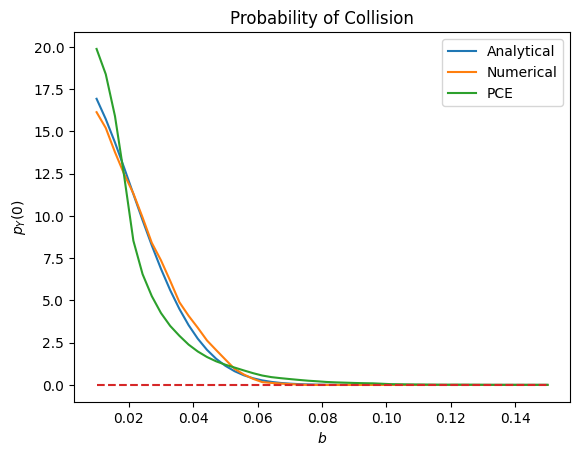

In [38]:
bvec = np.linspace(0.01, 0.15, 50)
p_Y_analytical = np.array([collision_analytical(b, p_X1, p_X2) for b in bvec])
p_Y_numerical = np.array([collision_numerical(b, x1_numerical, x2_numerical) for b in bvec])
p_Y_pce = np.array([collision_pce(b, x1_pce, x2_pce) for b in bvec])

plt.plot(bvec, p_Y_analytical, label='Analytical')
plt.plot(bvec, p_Y_numerical, label='Numerical')
plt.plot(bvec, p_Y_pce, label='PCE')
plt.plot(bvec, np.ones_like(bvec)*1e-3, linestyle='--')

plt.xlabel('$b$')
plt.ylabel('$p_Y(0)$')
plt.title('Probability of Collision')
plt.legend()
plt.savefig('collision.svg', bbox_inches='tight', transparent=True, format="svg")

In [39]:
flag_0, flag_1, flag_2 = False, False, False

for i, b in enumerate(bvec):
    if p_Y_analytical[i] < 1e-3 and not flag_0:
        print('Analytical: ', b)
        flag_0 = True
    if p_Y_numerical[i] < 1e-3 and not flag_1:
        print('Numerical: ', b)
        flag_1 = True
    if p_Y_pce[i] < 1e-3 and not flag_2:
        print('PCE: ', b)
        flag_2 = True

Numerical:  0.07571428571428569
Analytical:  0.0957142857142857
